In [52]:

import os
import random
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Resizing, RandomFlip
from tensorflow.keras.optimizers import Adam

EPOCH = 5

def load_dataset(validation_split=0.2,dec_factor=10):
    # Load the CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


    # Reduce the number of images by a factor of dec_factor
    train_images = train_images[::dec_factor]  # Take every Nth image
    train_labels = train_labels[::dec_factor]  # Corresponding labels
    test_images = test_images[::dec_factor]
    test_labels = test_labels[::dec_factor]


    # Split the training data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=validation_split, random_state=42)

    # Normalize pixel values to be between 0 and 1
    train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.0
    
    # Convert labels to one-hot encoding
    train_labels = to_categorical(train_labels, 10)
    val_labels = to_categorical(val_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_images, train_labels, val_images, val_labels, test_images, test_labels


def create_model():
    image_size = 128
    base_model = MobileNet( input_shape = (image_size,image_size,3),
                            include_top=False,
                             weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([        
        Resizing(image_size, image_size, interpolation="nearest", input_shape=train_images.shape[1:]),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])

    # Specify the learning rate
    
    # Instantiate the Adam optimizer with the default learning rate
    optimizer = Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [54]:
# Set the random seeds
os.environ['PYTHONHASHSEED'] = str(42)  # This variable influences the hash function's behavior in Python 3.3 and later.
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#Load the dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_dataset()
#Create the backbone model that will be used to train
model = create_model()
#Do the actual training
start = time.perf_counter()
history = model.fit(train_images, train_labels, epochs=EPOCH, validation_data=(val_images, val_labels))
end = time.perf_counter()
print(f"Manual timing: {end - start:.6f} seconds")

#Evaluate 
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


model.summary()

Epoch 1/5


2024-11-15 15:59:53.302827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


123/125 [============================>.] - ETA: 0s - loss: 1.2552 - accuracy: 0.5752

2024-11-15 15:59:56.592329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 6s 35ms/step - loss: 1.2482 - accuracy: 0.5765 - val_loss: 0.7876 - val_accuracy: 0.7290
Epoch 2/5
125/125 [==============================] - 3s 26ms/step - loss: 0.6134 - accuracy: 0.7928 - val_loss: 0.6474 - val_accuracy: 0.7810
Epoch 3/5
125/125 [==============================] - 3s 26ms/step - loss: 0.4762 - accuracy: 0.8393 - val_loss: 0.5861 - val_accuracy: 0.7930
Epoch 4/5
125/125 [==============================] - 3s 26ms/step - loss: 0.3914 - accuracy: 0.8695 - val_loss: 0.5684 - val_accuracy: 0.8000
Epoch 5/5
125/125 [==============================] - 3s 25ms/step - loss: 0.3318 - accuracy: 0.9007 - val_loss: 0.5636 - val_accuracy: 0.8010
Manual timing: 18.580526 seconds
32/32 - 1s - loss: 0.6273 - accuracy: 0.7750 - 620ms/epoch - 19ms/step
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_15 (Resizing)      (None, 128, 

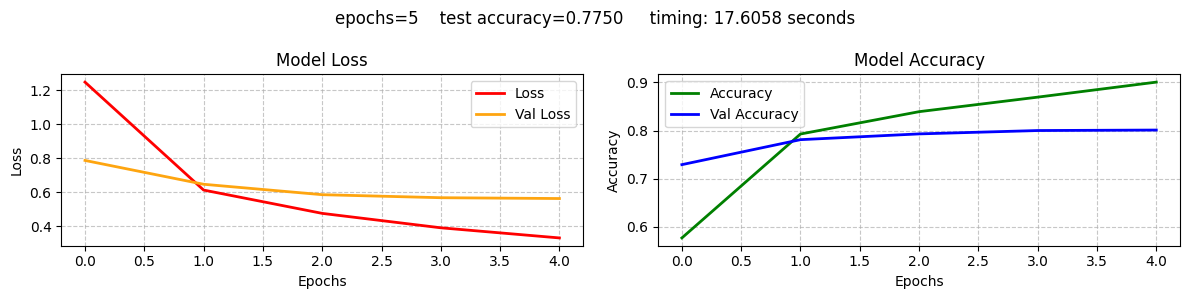

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_vs_val_metrics(history, figsize=(12, 3),extra_title = None):
    """
    Plot training and validation metrics (loss and accuracy) from model training history.
    
    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        The training history object returned by model.fit()
    figsize : tuple, optional
        Figure size as (width, height), default is (12, 5)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object containing both plots
    """
    # Define consistent styling
    METRICS_CONFIG = {
        'loss': {'color': 'red', 'subplot': 0, 'title': 'Model Loss'},
        'val_loss': {'color': '#FEA510', 'subplot': 0},
        'accuracy': {'color': 'green', 'subplot': 1, 'title': 'Model Accuracy'},
        'val_accuracy': {'color': 'blue', 'subplot': 1}
    }
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    axes = [ax1, ax2]
    
    if extra_title:
        plt.suptitle(extra_title)
    epochs = np.array(history.epoch)
    
    # Plot each metric
    for metric, values in history.history.items():
        if metric in METRICS_CONFIG:
            config = METRICS_CONFIG[metric]
            subplot_idx = config['subplot']
            ax = axes[subplot_idx]
            
            ax.plot(epochs, values, 
                   color=config['color'],
                   label=metric.replace('_', ' ').title(),
                   linewidth=2)
            
            # Set titles and labels only once per subplot
            if 'title' in config:
                ax.set_title(config['title'])
                ax.set_ylabel(config['title'].split()[1])

            ax.set_xlabel('Epochs')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend()

    plt.tight_layout()
    # return fig
plot_train_vs_val_metrics(history,extra_title='epochs='+str(EPOCH) +'    test accuracy='+str(f"{test_acc:.4f}") + f'     timing: {end - start:.4f} seconds')

# part 3

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_17 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 3217226 (12.27 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________
Epoch 1/5


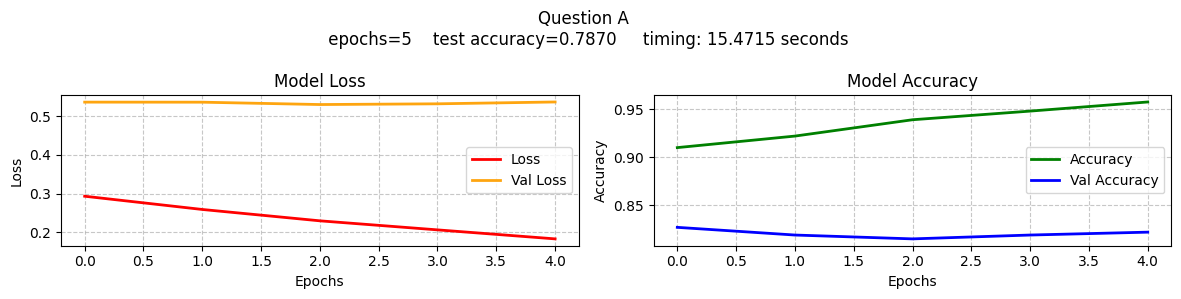

In [46]:
# a # Unfreeze the layers (base_model.trainable) so that the whole network can learn

for layer in model.layers:
    layer.trainable=True

[setattr(layer, 'trainable', True) for layer in model.layers]

model.summary()


start = time.perf_counter()
history = model.fit(train_images, train_labels, epochs=EPOCH, validation_data=(val_images, val_labels))
end = time.perf_counter()
print(f"Manual timing: {end - start:.6f} seconds")

#Evaluate 
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

plot_train_vs_val_metrics(history,extra_title='Question A \n epochs='+str(EPOCH) +'    test accuracy='+str(f"{test_acc:.4f}") + f'     timing: {end - start:.4f} seconds')

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_17 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 3217226 (12.27 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________
Epoch 1/5


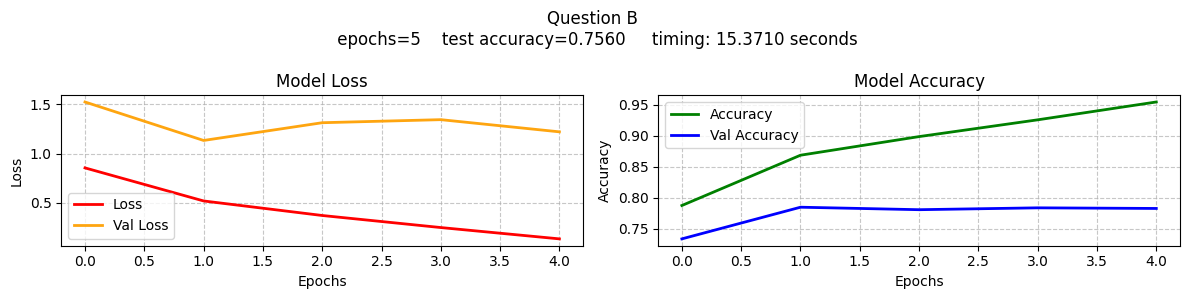

In [47]:

# B
model.optimizer.learning_rate = 0.01
model.summary()



start = time.perf_counter()
history = model.fit(train_images, train_labels, epochs=EPOCH, validation_data=(val_images, val_labels))
end = time.perf_counter()
print(f"Manual timing: {end - start:.6f} seconds")

#Evaluate 
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
plot_train_vs_val_metrics(history, extra_title='Question B \n epochs='+str(EPOCH)  +'    test accuracy='+str(f"{test_acc:.4f}") + f'     timing: {end - start:.4f} seconds')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 32

2024-11-15 15:54:23.600724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.6085

2024-11-15 15:54:32.428180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 11s 68ms/step - loss: 1.3793 - accuracy: 0.6085 - val_loss: 3.5786 - val_accuracy: 0.2610
Epoch 2/5
125/125 [==============================] - 8s 60ms/step - loss: 0.7393 - accuracy: 0.7605 - val_loss: 3.6634 - val_accuracy: 0.3810
Epoch 3/5
125/125 [==============================] - 8s 66ms/step - loss: 0.6010 - accuracy: 0.8027 - val_loss: 2.3860 - val_accuracy: 0.4980
Epoch 4/5
125/125 [==============================] - 8s 61ms/step - loss: 0.4940 - accuracy: 0.8330 - val_loss: 1.5525 - val_accuracy: 0.6310
Epoch 5/5
125/125 [==============================] - 8s 61ms/step - loss: 0.4389 - accuracy: 0.8533 - val_loss: 2.0939 - val_accuracy: 0.5720
Manual timing: 42.533706 seconds
32/32 - 1s - loss: 2.1235 - accuracy: 0.5430 - 602ms/epoch - 19ms/step
Test accuracy: 0.5429999828338623, Test loss: 2.1234633922576904


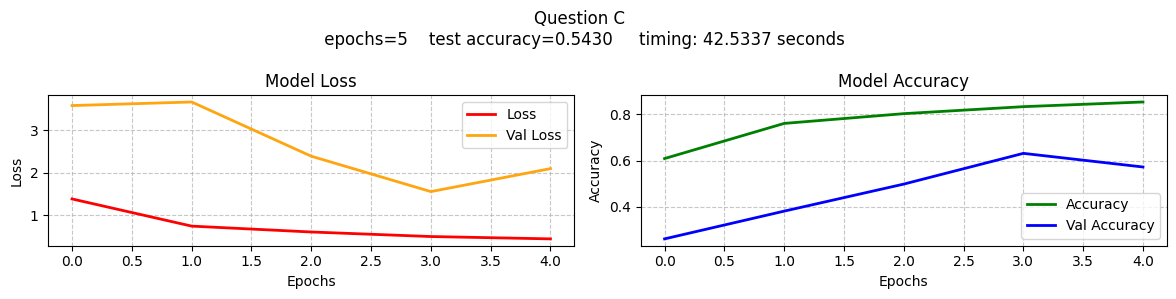

In [48]:
# C

# Copy existing layers except last one
new_model = tf.keras.Sequential(model.layers[:-1])

# Add dropout and final layer
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.Dense(10, activation='softmax'))

print(new_model.summary())
print("Label shape:", train_labels.shape)
print("Sample labels:", train_labels[:3])

# Add optimizer and metrics
new_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training
start = time.perf_counter()
history = new_model.fit(
    train_images, 
    train_labels, 
    epochs=EPOCH, 
    validation_data=(val_images, val_labels)
)
end = time.perf_counter()
print(f"Manual timing: {end - start:.6f} seconds")

# Evaluation 
test_loss, test_acc = new_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

plot_train_vs_val_metrics(history, extra_title='Question C \n epochs='+str(EPOCH)+'    test accuracy='+str(f"{test_acc:.4f}") + f'     timing: {end - start:.4f} seconds')

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 32

2024-11-15 15:55:05.951888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:55:05.966160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:55:06.770924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.6952

2024-11-15 15:55:15.839115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 11s 71ms/step - loss: 0.9755 - accuracy: 0.6952 - val_loss: 1.9678 - val_accuracy: 0.5560
Epoch 2/5
  2/125 [..............................] - ETA: 7s - loss: 0.9767 - accuracy: 0.6562

2024-11-15 15:55:17.373210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 62ms/step - loss: 0.6704 - accuracy: 0.7845 - val_loss: 2.2362 - val_accuracy: 0.4770
Epoch 3/5
  3/125 [..............................] - ETA: 6s - loss: 0.6474 - accuracy: 0.7604

2024-11-15 15:55:25.141500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 63ms/step - loss: 0.5762 - accuracy: 0.8095 - val_loss: 1.8644 - val_accuracy: 0.5720
Epoch 4/5
  3/125 [..............................] - ETA: 6s - loss: 0.5260 - accuracy: 0.8333

2024-11-15 15:55:32.976710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 62ms/step - loss: 0.5325 - accuracy: 0.8238 - val_loss: 4.0555 - val_accuracy: 0.4010
Epoch 5/5
  3/125 [..............................] - ETA: 6s - loss: 0.7746 - accuracy: 0.7708

2024-11-15 15:55:40.780583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 63ms/step - loss: 0.4897 - accuracy: 0.8317 - val_loss: 1.0056 - val_accuracy: 0.6850
Manual timing: 42.689686 seconds


2024-11-15 15:55:48.757821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 - 2s - loss: 0.9535 - accuracy: 0.6940 - 2s/epoch - 48ms/step
Test accuracy: 0.6940000057220459, Test loss: 0.9535123705863953


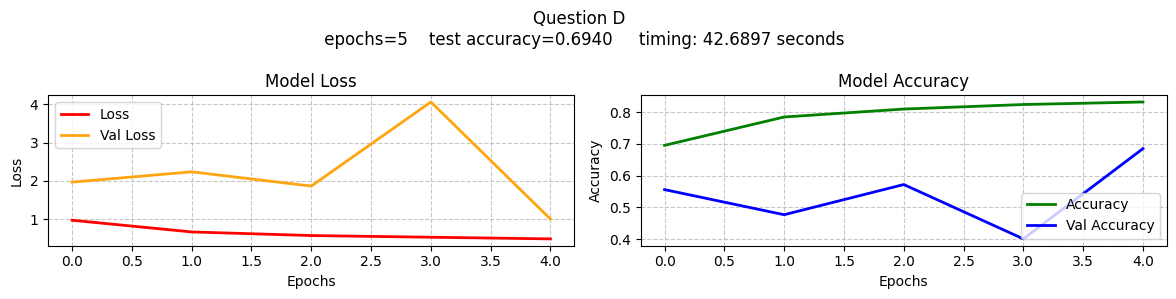

In [49]:
# D
import tensorflow as tf
import time
import os

# Create data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal")
])

# Create augmented dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(1000).batch(32)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

# Define new model with augmentation
new_model = tf.keras.Sequential(model.layers[:-1])
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.Dense(10, activation='softmax'))

new_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print(new_model.summary())
print("Label shape:", train_labels.shape)
print("Sample labels:", train_labels[:3])

# Train with augmented data
start = time.perf_counter()
history = new_model.fit(train_ds, epochs=EPOCH, validation_data=val_ds)
end = time.perf_counter()
print(f"Manual timing: {end - start:.6f} seconds")

test_loss, test_acc = new_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
plot_train_vs_val_metrics(history, extra_title='Question D \n epochs='+str(EPOCH)+'    test accuracy='+str(f"{test_acc:.4f}") + f'     timing: {end - start:.4f} seconds')

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, ResNet50
import time

def create_model(model_name='mobilenet'):
    """
    Create model with specified architecture
    Args:
        model_name: 'mobilenet' or 'resnet'
    """
    image_size = 128
    
    if model_name.lower() == 'mobilenet':
        base_model = MobileNet(input_shape=(image_size, image_size, 3),
                             include_top=False,
                             weights='imagenet')
    elif model_name.lower() == 'resnet':
        # Using ResNet50 since ResNet18 isn't directly available in tf.keras.applications
        # This is the smallest ResNet variant available in TensorFlow
        base_model = ResNet50(input_shape=(image_size, image_size, 3),
                            include_top=False,
                            weights='imagenet')
    else:
        raise ValueError("model_name must be 'mobilenet' or 'resnet'")
        
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([        
        layers.Resizing(image_size, image_size, interpolation="nearest", 
                       input_shape=train_images.shape[1:]),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = Adam()
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Train and evaluate ResNet
resnet_model = create_model('resnet')
start = time.perf_counter()
history_resnet = resnet_model.fit(train_ds, 
                                 epochs=5, 
                                 validation_data=val_ds)
end = time.perf_counter()
resnet_training_time = end - start

# Measure ResNet inference latency
def measure_inference_latency(model, test_data):
    latencies = []
    for _ in range(100):  # Run 100 times to get average
        start = time.perf_counter()
        model.predict(test_data[:1])  # Predict single image
        end = time.perf_counter()
        latencies.append(end - start)
    return sum(latencies) / len(latencies)

resnet_latency = measure_inference_latency(resnet_model, test_images)

# Train and measure MobileNet for comparison
mobilenet_model = create_model('mobilenet')
start = time.perf_counter()
history_mobilenet = mobilenet_model.fit(train_ds, 
                                      epochs=5, 
                                      validation_data=val_ds)
end = time.perf_counter()
mobilenet_training_time = end - start

mobilenet_latency = measure_inference_latency(mobilenet_model, test_images)

# Print comparison results
print("\nComparison Results:")
print(f"ResNet Training Time: {resnet_training_time:.2f} seconds")
print(f"MobileNet Training Time: {mobilenet_training_time:.2f} seconds")
print(f"ResNet Average Inference Latency: {resnet_latency*1000:.2f} ms")
print(f"MobileNet Average Inference Latency: {mobilenet_latency*1000:.2f} ms")

# Evaluate accuracy
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_images, test_labels, verbose=2)
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_images, test_labels, verbose=2)

print(f"\nResNet Test Accuracy: {resnet_test_acc:.4f}")
print(f"MobileNet Test Accuracy: {mobilenet_test_acc:.4f}")

Epoch 1/5


2024-11-15 15:55:51.865120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:55:51.879843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:55:52.707843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 2.3130 - accuracy: 0.1123

2024-11-15 15:55:59.726737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 11s 76ms/step - loss: 2.3130 - accuracy: 0.1123 - val_loss: 2.3042 - val_accuracy: 0.0810
Epoch 2/5
  3/125 [..............................] - ETA: 5s - loss: 2.2943 - accuracy: 0.1562

2024-11-15 15:56:02.915031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 7s 59ms/step - loss: 2.2832 - accuracy: 0.1310 - val_loss: 2.2877 - val_accuracy: 0.1270
Epoch 3/5
  3/125 [..............................] - ETA: 5s - loss: 2.2926 - accuracy: 0.1250

2024-11-15 15:56:10.313908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 7s 59ms/step - loss: 2.2686 - accuracy: 0.1488 - val_loss: 2.2609 - val_accuracy: 0.1780
Epoch 4/5
  3/125 [..............................] - ETA: 5s - loss: 2.2514 - accuracy: 0.1875

2024-11-15 15:56:17.658958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 7s 58ms/step - loss: 2.2515 - accuracy: 0.1615 - val_loss: 2.2454 - val_accuracy: 0.1590
Epoch 5/5
  3/125 [..............................] - ETA: 5s - loss: 2.2665 - accuracy: 0.1458

2024-11-15 15:56:24.927522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 7s 58ms/step - loss: 2.2329 - accuracy: 0.1957 - val_loss: 2.2345 - val_accuracy: 0.2370


2024-11-15 15:56:32.516193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 22ms/step


Epoch 1/5


2024-11-15 15:56:38.031980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:56:38.045451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 15:56:38.452706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.5925

2024-11-15 15:56:41.766878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 5s 34ms/step - loss: 1.2013 - accuracy: 0.5925 - val_loss: 0.7568 - val_accuracy: 0.7370
Epoch 2/5
  7/125 [>.............................] - ETA: 2s - loss: 0.7896 - accuracy: 0.7366

2024-11-15 15:56:43.400694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 3s 24ms/step - loss: 0.6031 - accuracy: 0.8008 - val_loss: 0.6500 - val_accuracy: 0.7820
Epoch 3/5
  7/125 [>.............................] - ETA: 2s - loss: 0.5276 - accuracy: 0.8259

2024-11-15 15:56:46.476260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 3s 25ms/step - loss: 0.4770 - accuracy: 0.8428 - val_loss: 0.5745 - val_accuracy: 0.7930
Epoch 4/5
  7/125 [>.............................] - ETA: 2s - loss: 0.3933 - accuracy: 0.8705

2024-11-15 15:56:49.608529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 3s 24ms/step - loss: 0.4065 - accuracy: 0.8690 - val_loss: 0.5337 - val_accuracy: 0.8080
Epoch 5/5
  7/125 [>.............................] - ETA: 2s - loss: 0.3696 - accuracy: 0.8884

2024-11-15 15:56:52.686317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 3s 24ms/step - loss: 0.3594 - accuracy: 0.8867 - val_loss: 0.5097 - val_accuracy: 0.8180


2024-11-15 15:56:55.861669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step

Comparison Results:
ResNet Training Time: 40.39 seconds
MobileNet Training Time: 17.72 seconds
ResNet Average Inference Latency: 53.60 ms
MobileNet Average Inference Latency: 38.85 ms


2024-11-15 15:56:59.873910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 - 3s - loss: 2.2338 - accuracy: 0.2520 - 3s/epoch - 104ms/step


2024-11-15 15:57:03.130799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 - 2s - loss: 0.5866 - accuracy: 0.7970 - 2s/epoch - 50ms/step

ResNet Test Accuracy: 0.2520
MobileNet Test Accuracy: 0.7970


In [55]:
print(mobilenet_model.summary())
print(resnet_model.summary())


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_14 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_21 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 10250 (40.04 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________
None
Model

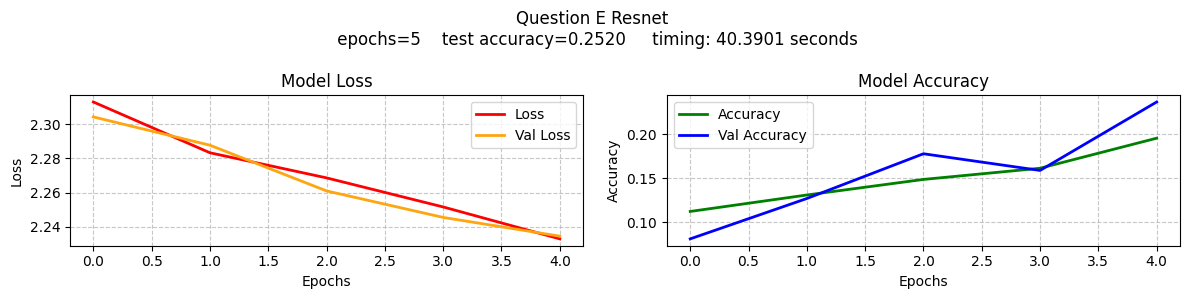

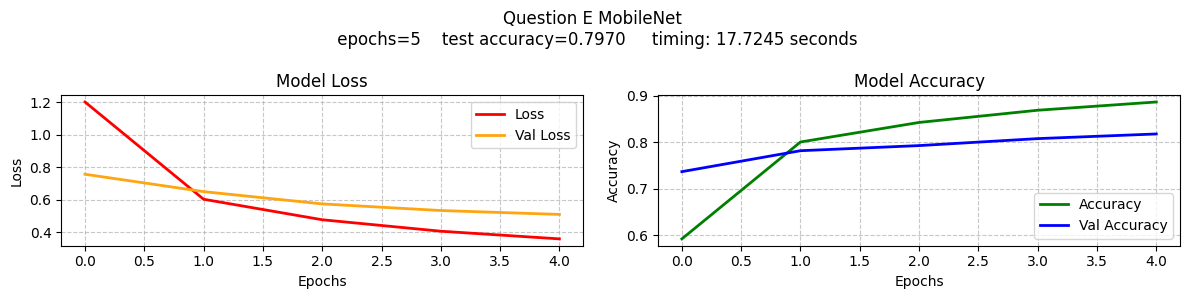

In [51]:
plot_train_vs_val_metrics(history_resnet, extra_title='Question E Resnet \n epochs='+str(EPOCH)+'    test accuracy='+str(f"{resnet_test_acc:.4f}") + f'     timing: {resnet_training_time:.4f} seconds')

plot_train_vs_val_metrics(history_mobilenet, extra_title='Question E MobileNet \n epochs='+str(EPOCH)+'    test accuracy='+str(f"{mobilenet_test_acc:.4f}") + f'     timing: {mobilenet_training_time:.4f} seconds')